<a href="https://colab.research.google.com/github/Sujal-vajire/Attention-model-/blob/main/Transformer20EpochWindmill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt

Tensorflow version: 2.8.2


In [2]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='uniform',
                                              trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='uniform',
                                           trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:, :, :4], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear  # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1)  # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)  # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1)  # shape = (batch, seq_len, 2)

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

In [3]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x / np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

In [4]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

            # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
        self.linear = Dense(input_shape[0][-1],
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

In [5]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config

In [6]:
data = pd.read_csv('power.csv',)

In [9]:
data = data[['Timestamp','Power(kW)']].iloc[:136731,:]
data.set_index('Timestamp',drop=True,inplace=True)
data.tail()

,Power(kW)
Timestamp,
2021-08-14 23:10:00,2757.728271
2021-08-14 23:20:00,2758.323242
2021-08-14 23:30:00,2759.243408
2021-08-14 23:40:00,2761.261719
2021-08-14 23:50:00,2758.593262


In [10]:
from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
dataset = data['Power(kW)'].to_numpy()

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)
trainset = dataset_list[:int(len(dataset_list) * (1 - test_percentage))]
testset = dataset_list[int(len(dataset_list) * (1 - test_percentage)):]

x_train = trainset[:, :-1]
y_train = trainset[:, -1:]
x_test = testset[:, :-1]
y_test = testset[:, -1:]

print('x_train.shape:' + str(x_train.shape))
print('y_train.shape:' + str(y_train.shape))
print('x_test.shape:' + str(x_test.shape))
print('y_test.shape' + str(y_test.shape))

x_train.shape:(109343, 50)
y_train.shape:(109343, 1)
x_test.shape:(27336, 50)
y_test.shape(27336, 1)


In [11]:
batch_size = 25
seq_len = 50

d_k = 25
d_v = 25
n_heads = 2
ff_dim = 25

In [12]:
time_embedding_c = Time2Vector(seq_len)
attn_layer1_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer2_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer3_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

in_seq_c = Input(shape=(seq_len, 1))
x_c = time_embedding_c(in_seq_c)
x_c = Concatenate(axis=-1)([in_seq_c, x_c])
x_c = attn_layer1_c((x_c, x_c, x_c))
x_c = attn_layer2_c((x_c, x_c, x_c))
x_c = attn_layer3_c((x_c, x_c, x_c))
x_c = GlobalAveragePooling1D(data_format='channels_first')(x_c)
x_c = Dropout(0.1)(x_c)
x_c = Dense(64, activation='relu')(x_c)
x_c = Dropout(0.1)(x_c)
out_c = Dense(1, activation='linear')(x_c)

model = Model(inputs=[in_seq_c], outputs=[out_c])

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])


In [13]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 50, 2)        200         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 50, 3)        0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 50, 3)       943         ['concatenate[0][0]',        

In [14]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=20)

Epoch 1/20
4374/4374 [==============================] - 193s 41ms/step - loss: 0.0147 - mae: 0.0825 - mape: 203.0759
Epoch 2/20
4374/4374 [==============================] - 175s 40ms/step - loss: 0.0098 - mae: 0.0671 - mape: 206.0609
Epoch 3/20
4374/4374 [==============================] - 176s 40ms/step - loss: 0.0090 - mae: 0.0629 - mape: 124.3249
Epoch 4/20
4374/4374 [==============================] - 176s 40ms/step - loss: 0.0085 - mae: 0.0608 - mape: 498.5223
Epoch 5/20
4374/4374 [==============================] - 177s 40ms/step - loss: 0.0082 - mae: 0.0595 - mape: 422.0997
Epoch 6/20
4374/4374 [==============================] - 177s 41ms/step - loss: 0.0080 - mae: 0.0584 - mape: 500.3313
Epoch 7/20
4374/4374 [==============================] - 177s 41ms/step - loss: 0.0078 - mae: 0.0578 - mape: 619.6981
Epoch 8/20
4374/4374 [==============================] - 177s 41ms/step - loss: 0.0074 - mae: 0.0565 - mape: 1027.5215
Epoch 9/20
4374/4374 [==============================] - 178s 41

In [17]:
from sklearn.metrics import mean_squared_error
y_predict = model.predict(x_test)
scaler1=MinMaxScaler(feature_range=(0,1))
predicted1=scaler1.fit_transform(y_predict)

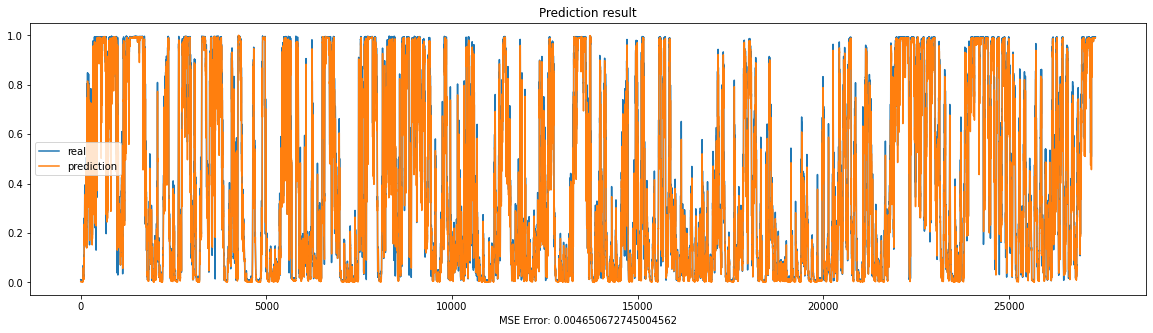

In [18]:
fig=plt.figure(figsize=(20,5))
plt.figure(1)
plt.plot(y_test, label='real')
plt.plot(predicted1, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_test, predicted1)))
plt.legend()
plt.title('Prediction result')
plt.show()

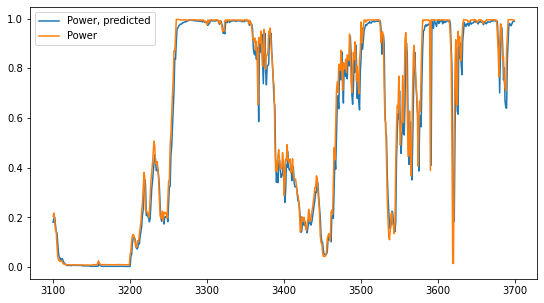

In [19]:
fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(3100,3700),predicted1[3100:3700],label='Power, predicted')
plt.plot(np.arange(3100,3700),y_test[3100:3700],label="Power")
plt.legend()

In [20]:
from sklearn import metrics
score = metrics.mean_squared_error(y_test, predicted1)
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.004650672745004562


In [21]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(y_test, predicted1)
print("Final score (MAE): {}".format(MAE))

Final score (MAE): 0.03932878104778321


In [22]:
import numpy as np

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(y_test, predicted1))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.06819584111223032


In [23]:
from sklearn.metrics import r2_score
R2 = r2_score(y_test, predicted1, multioutput='variance_weighted')
print("Final score (R2): {}".format(R2))

Final score (R2): 0.9669601781302756


In [24]:
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis

print("Final score (skew):")
print(skew(predicted1, axis=0, bias=True))

Final score (skew):
[0.5877378]


In [25]:
print("Final score (kurtosis):")
print(kurtosis(predicted1, axis=0, bias=True))

Final score (kurtosis):
[-1.2453885]
